In [1]:
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
from scipy import stats
from math import *
from numpy import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval, PercentileInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch,SinhStretch, PowerStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
from regions import PixCoord
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion
from regions import CircleSkyRegion, CirclePixelRegion
from ast import literal_eval
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import matplotlib
plt.style.use(['science'])
import pickle
from astropy.wcs.utils import skycoord_to_pixel
import ast
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import figure, cm
from photutils.aperture import SkyCircularAperture
from photutils.aperture import aperture_photometry
from image_processing import snr_rms
from image_processing import read_fits
from os.path import exists
plt.rcParams.update({'figure.max_open_warning': 1000})

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
data_path = "/Users/arames52/Research/Data/Images/ALMA/"
residual_path = "/Users/arames52/Research/Data/GnS_profile/Gaussian/Residuals/"

In [3]:
images = sorted(glob.glob(data_path + "*.fits"))

In [4]:
bcg_coords_df = pd.read_csv("/Users/arames52/Research/Data/BCG_coords.txt", delim_whitespace = True,
names = ['bcg', 'ra', 'dec'])
bcg_coords = {}
for ind, row in bcg_coords_df.iterrows():
    bcg_coords[row['bcg']] = [row['ra'], row['dec']]

In [86]:
def cutout_images(header, data, wcs, bcg):
    ra, dec = bcg_coords[bcg][0], bcg_coords[bcg][1]
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = u.Quantity((3,3), u.arcsec)
    image_cutout = Cutout2D(data, position = position, size = s, wcs = wcs).data
    image_cutout[image_cutout<0] = 0
    return image_cutout

In [87]:
with open("/Users/arames52/Research/Data/rms.pkl", "rb") as f:
    rms_dict = pickle.load(f)
with open("/Users/arames52/Research/Data/snr.pkl", "rb") as f:
    snr_dict = pickle.load(f)

In [88]:
contour_steps = {'CDFS-18':25, 'CDFS19':1, 'ES1-12':1,'ES1-26':1, 'ES1-35':1, 'XMM-19':1, 'XMM-27':1,
                'ES1-18':1, 'ES1-25':1, 'ES1_z_0.88':1, 'ES1_z_0.99':1, 'ES1_z_0.99b':1, 
                'ES1_z_1.60':1, 'XMM-11':1, 'XMM-29':1, 'XMM-30':1,'XMM-113':1, 'XMM_z_0.81':1, 
                'XMM_z_0.9':1, 'XMM_z_1.0':1, 'ES1-34':2, 'ES1_z_1.04':2, 'ES1_z_1.38':2, 'ES1_z_1.40':2,
                'ES1_z_1.70':4, 'ES1_z_1.65':10}

<ipython-input-89-b62a466c9fc0>:16: UserWarning: No contour levels were found within the data range.
  ax[1].contour(cutout_residual, levels = levels, colors='white', linewidths = 0.5, zorder = 1, alpha = 1)


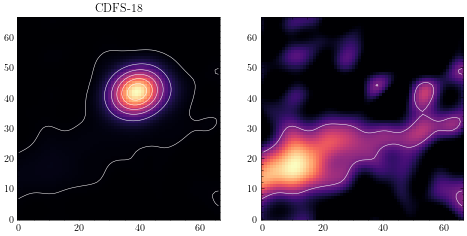

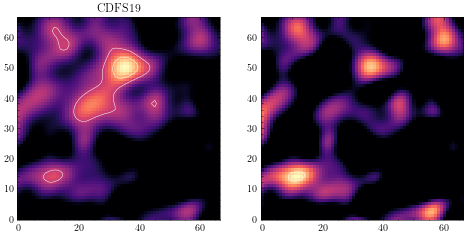

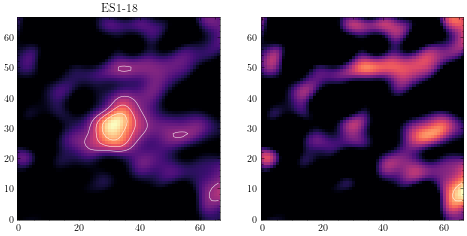

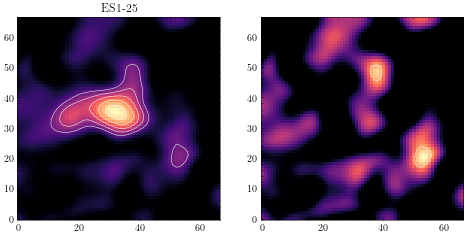

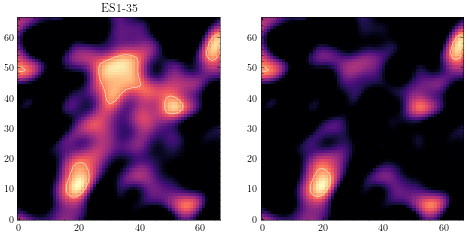

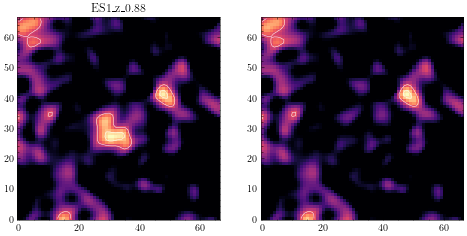

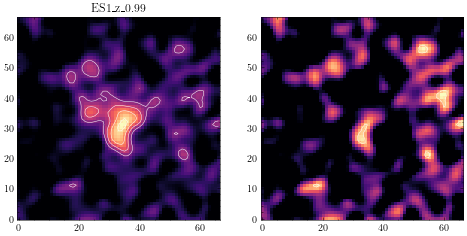

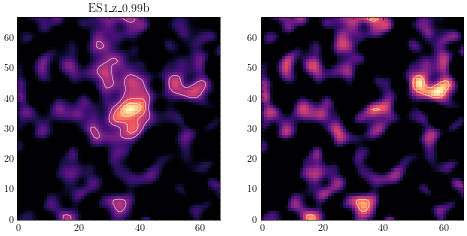

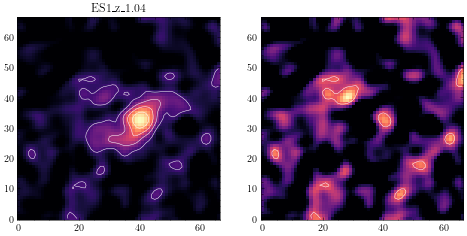

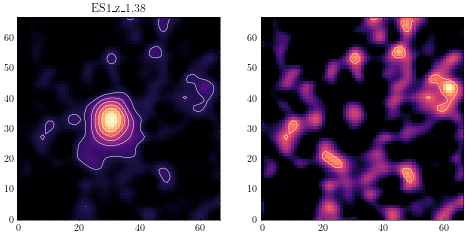

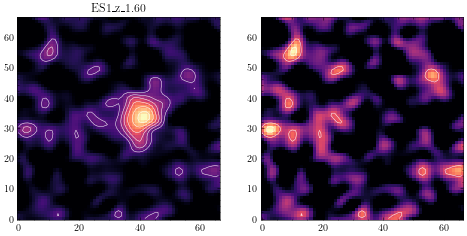

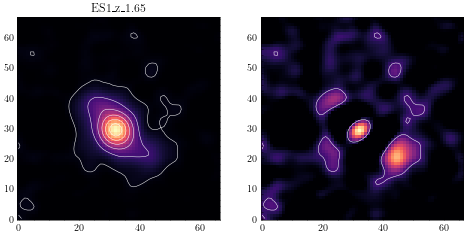

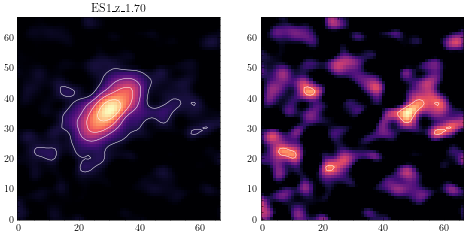

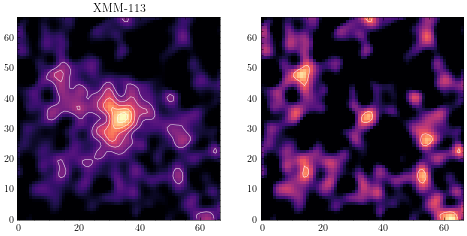

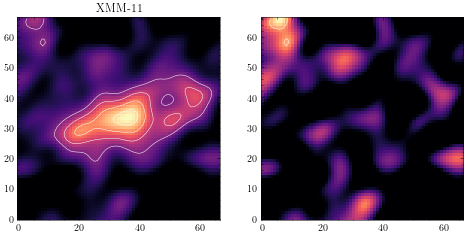

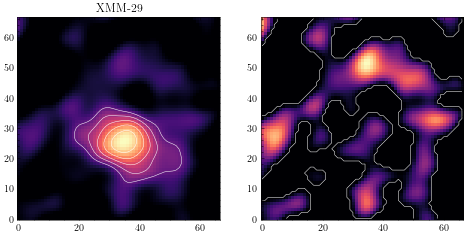

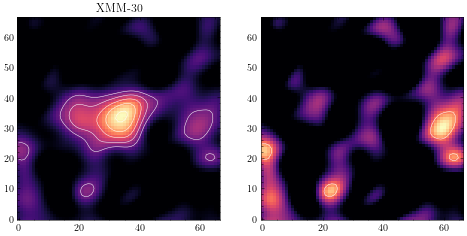

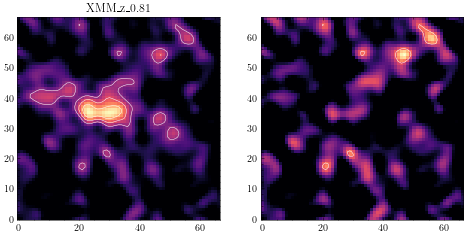

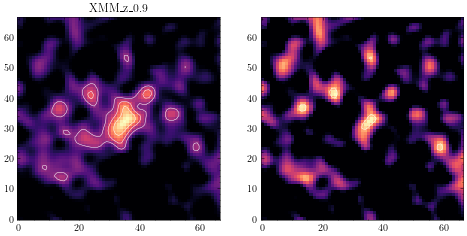

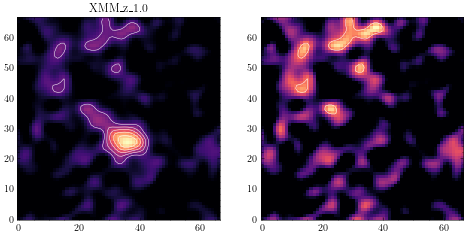

In [89]:
for file in images:
    fig,ax = plt.subplots(1,2, figsize = (8,5))
    bcg_name = file.split("_natural.fits")[0].split(data_path)[-1]
    
    h,d,w = read_fits(file, 'alma')
    rh,rd,rw = read_fits(residual_path + bcg_name + "_residual.image.fits", 'alma')
    def plot_norm(data):
        return ImageNormalize(data, stretch=LinearStretch(), interval=ZScaleInterval())
    
    cutout_image = cutout_images(h,d,w, bcg_name)
    cutout_residual = cutout_images(rh,rd,rw, bcg_name)
    levels = np.arange(rms_dict[bcg_name]*2, rms_dict[bcg_name]*snr_dict[bcg_name], contour_steps[bcg_name]*rms_dict[bcg_name])
    ax[0].imshow(cutout_image, origin = 'lower', cmap = 'magma')
    ax[0].contour(cutout_image, levels = levels, colors='white', linewidths = 0.5, zorder = 1, alpha = 1)
    ax[1].imshow(cutout_residual, origin = 'lower', cmap = 'magma')
    ax[1].contour(cutout_residual, levels = levels, colors='white', linewidths = 0.5, zorder = 1, alpha = 1)
    ax[0].set_title(bcg_name)
#     ax.scatter(h['CRPIX1'], h['CRPIX2'], marker = 'x', color = 'red')
#     ax.set_xlim(300,500)
#     ax.set_ylim(300,500)

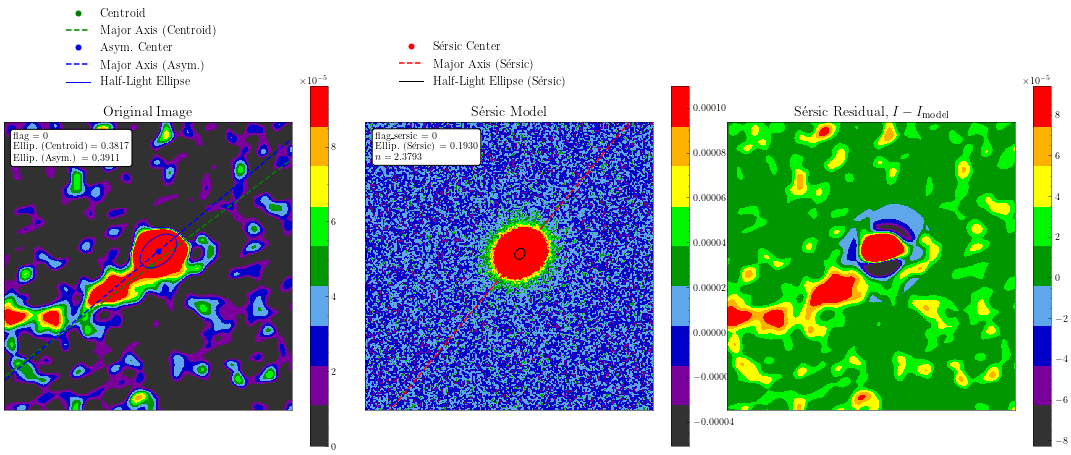

In [37]:
#ALMA Images
alma_images_path = "/Users/arames52/Research/Data/Images/ALMA/"
alma_images = sorted(glob.glob(alma_images_path + "*.fits"))
# Gaussian Residuals
residual_path = "/Users/arames52/Research/Data/GnS_profile/Gaussian/Residuals/"
residual_postfix = "_residual.image.fits"
#IMFIT Results
with open("/Users/arames52/Research/Data/GnS_profile/Gaussian/Residuals/imfit_results.pkl", "rb") as f:
    imfit_results = pickle.load(f)
#BCG Coordinates
bcg_coords_df = pd.read_csv("/Users/arames52/Research/Data/BCG_coords.txt", delim_whitespace = True,
names = ['bcg', 'ra', 'dec'])
bcg_coords = {}
for ind, row in bcg_coords_df.iterrows():
    bcg_coords[row['bcg']] = [row['ra'], row['dec']]
#RMS and SNR dict
with open("/Users/arames52/Research/Data/rms.pkl", "rb") as f:
    rms_dict = pickle.load(f)
with open("/Users/arames52/Research/Data/snr.pkl", "rb") as f:
    snr_dict = pickle.load(f)
# Function to read the fits image and make 3"x3" cutout image of the same
def read_fits_cutout(file, bcg):
    
    hdu = fits.open(file)[0]
    header = hdu.header
    data = hdu.data[0,0,:,:]
    wcs = WCS(header, naxis = 2)
    data = np.nan_to_num(data)
    data[data<0] = 0

    ra, dec = bcg_coords[bcg][0], bcg_coords[bcg][1]
    position = SkyCoord(ra, dec, frame = 'fk5', unit = 'deg')
    s = u.Quantity((8,8), u.arcsec)
    image_cutout = Cutout2D(data, position = position, size = s, wcs = wcs).data
#     image_cutout[image_cutout<0] = 0

    bmaj = header['BMAJ']*u.deg.to(u.arcsec)/0.045
    bmin = header['BMIN']*u.deg.to(u.arcsec)/0.045
    pa = (header['BPA'] + 90)*u.deg.to(u.rad)
    psf = Gaussian2DKernel(x_stddev = gaussian_fwhm_to_sigma*bmaj, y_stddev = gaussian_fwhm_to_sigma*bmin, theta = pa, x_size = image_cutout.shape[0], y_size = image_cutout.shape[1]).array
    return data, header, wcs, image_cutout, psf
#Compute Sersic Profile
def compute_sersic(image, weightmap, psf, bcg):
    
    threshold = photutils.detect_threshold(image, 1.5, background = None)
    npixels = 5 
    segm = photutils.detect_sources(image, threshold, npixels = 5)
    label = argmax(segm.areas) + 1
    segmap = segm.data == label
    segmap_float = ndi.uniform_filter(float64(segmap), size=20)
    segmap = segmap_float > 0.5
    source_morphs = statmorph.source_morphology(image, segmap, gain=1, psf = psf)
    morph = source_morphs[0]
    
    return morph

for file in alma_images:
    
    bcg = file.split(alma_images_path)[-1].split("_natural.fits")[0]
    data, header, wcs, image_cutout, psf = read_fits_cutout(file, bcg)
    weightmap = np.full(image_cutout.shape, rms_dict[bcg])
    morph = compute_sersic(image_cutout, weightmap, psf,bcg)
    fig = make_figure(morph)
    break

In [16]:
from astropy.wcs.utils import proj_plane_pixel_area as pa
from astropy.wcs.utils import proj_plane_pixel_scales as ps

NoOverlapError: Arrays do not overlap.

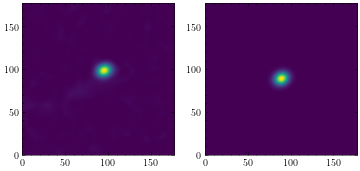

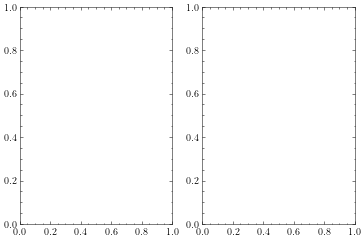

In [40]:
for file in alma_images:
    fig,ax = plt.subplots(1,2)
    data, header, wcs, image_cutout, psf = read_fits_cutout(file, bcg)
    bmaj = header['BMAJ']*u.deg.to(u.arcsec)/0.045
    bmin = header['BMIN']*u.deg.to(u.arcsec)/0.045
    pa = (header['BPA'] + 90)*u.deg.to(u.rad)
    psf = Gaussian2DKernel(x_stddev = gaussian_fwhm_to_sigma*bmaj, y_stddev = gaussian_fwhm_to_sigma*bmin, theta = pa, x_size = image_cutout.shape[0], y_size = image_cutout.shape[1]).array
    ax[0].imshow(image_cutout, origin = 'lower')
    ax[1].imshow(psf, origin = 'lower')
    

ModuleNotFoundError: No module named 'pybdsf'